In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
image_size = 300
batch_size = 16

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

train_path_second = '../input/cassava-disease/train/train'

In [4]:
second_id = []
second_label = []

for img in os.listdir(os.path.join(train_path_second, 'cbb')):
    second_id.append('/cbb/'+img)
    second_label.append('0')
    
for img in os.listdir(os.path.join(train_path_second, 'cbsd')):
    second_id.append('/cbsd/'+img)
    second_label.append('1')
    
for img in os.listdir(os.path.join(train_path_second, 'cgm')):
    second_id.append('/cgm/'+img)
    second_label.append('2')
    
for img in os.listdir(os.path.join(train_path_second, 'cmd')):
    second_id.append('/cmd/'+img)
    second_label.append('3')
    
for img in os.listdir(os.path.join(train_path_second, 'healthy')):
    second_id.append('/healthy/'+img)
    second_label.append('4')

In [5]:
train_second = pd.DataFrame({'image_id':second_id, 'label':second_label})

train_second.head()

,image_id,label
0,/cbb/train-cbb-0.jpg,0
1,/cbb/train-cbb-1.jpg,0
2,/cbb/train-cbb-10.jpg,0
3,/cbb/train-cbb-100.jpg,0
4,/cbb/train-cbb-101.jpg,0


In [6]:
del second_id
del second_label

In [7]:
def image_path_first(image):
    return os.path.join(train_path,image)

def image_path_second(image):
    return os.path.join(train_path_second, image)

train['image_id'] = train['image_id'].apply(image_path_first)
train_second['image_id'] = train_second['image_id'].apply(image_path_second)

In [8]:
train['label'] = train['label'].astype('str')

In [9]:
# combine dataframe to train

combined_train = pd.concat([train, train_second], ignore_index=True)

combined_train.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


In [10]:
combined_train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [11]:
del train
del train_second

train = combined_train

del combined_train
del train_path
del train_path_second

In [12]:
train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [13]:
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [14]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                rescale = 1./255)

val_gen = ImageDataGenerator(rescale=1./255)

In [15]:
def build_efficientnet_b3():
    model = Sequential()
    model.add(EfficientNetB3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


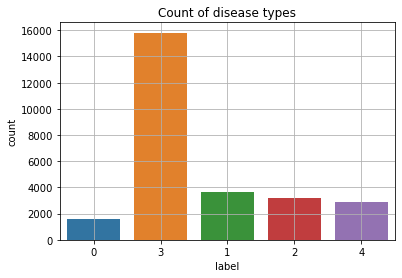

In [16]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [17]:
scores = []
fold_var = 1

In [18]:
for train_idx, val_idx in SKF.split(train, train['label']):
    training_data = train.iloc[train_idx]
    validation_data = train.iloc[val_idx]
    
    # generator
    train_generator = train_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                batch_size=batch_size, seed=1, shuffle=True,
                                                class_mode='categorical', target_size=(image_size,image_size))

    validation_generator = val_gen.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   batch_size=batch_size, seed=1, shuffle=False,
                                                   class_mode='categorical', target_size=(image_size,image_size))
    
    print('Train length:', len(train_generator))
    print('Val length:', len(validation_generator))
    
    # build model
    model = build_efficientnet_b3()
    
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    # callbacks
    checkpoint_filename = './k_folds_model/' + str(fold_var) + '.ckpt'
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=2, min_lr=0, verbose=1)
    
    # fit
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
                        
    # save model
    model.save(checkpoint_filename)
    model_filename = './k_folds_model/' + str(fold_var) + '.h5'
    
    # evaluate
    results = model.evaluate(validation_generator)
    scores.append(results)
    
    clear_session()
    fold_var += 1

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5656 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 21397 validated image filenames belonging to 5 classes.


C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5656 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 21397 validated image filenames belonging to 5 classes.
Train length: 1338
Val length: 1338
Epoch 1/30
1338/1338 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.7418
Epoch 00001: val_loss improved from inf to 1.36735, saving model to ./k_folds_model\1.ckpt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./k_folds_model\1.ckpt\assets
1338/1338 [==============================] - 647s 484ms/step - loss: 0.7362 - accuracy: 0.7418 - val_loss: 1.3673 - val_accuracy: 0.4618
Epoch 2/30
1338/1338 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.8015
Epoch 00002: val_loss did not improve from 1.36735
1338/1338 [==============================] - 586s 438ms/step - loss: 0.5817 - accuracy: 0.8015 - val_loss: 7.2965 - val_accuracy

OpError: 

In [ ]:
print('Train loss:'+train_loss)
print('Train accuracy:'+train_accuracy)
print('Val loss:'+validation_loss)
print('Val accuracy:'+validation_accuracy)

print(val_acc)

In [ ]:
test = pd.read_csv('../input/cassava-disease/sample_submission_file.csv')

In [ ]:
test_path = '../input/cassava-disease/test/test/0'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)
test['label'].replace('cbb', '0')
test['label'].replace('cbsd', '1')
test['label'].replace('cgm', '2')
test['label'].replace('cmd', '3')
test['label'].replace('healthy', '4')

In [ ]:
test_generator = val_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.efficientnet.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

In [ ]:
output = model.predict(test_generator)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, output, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

In [ ]:
print(model.predict(load_img('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')))